In [145]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Data Overview

Our raw dataset contains multiple tables, which we will later use to create a single table for our analysis

In [3]:
heartrate_seconds = pd.read_csv('data/heartrate_seconds_merged.csv')
print(f'Number of observations in the dataset: {len(heartrate_seconds)}')
heartrate_seconds.head()

Number of observations in the dataset: 2483658


,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101


In [4]:
unique_users_heartrate_seconds = heartrate_seconds["Id"].unique()
print(f'Id of unique users in the dataset: {", ".join([str(x) for x in unique_users_heartrate_seconds])}')
print(f'\nNumber of unique users in the dataset: {len(unique_users_heartrate_seconds)}')

Id of unique users in the dataset: 2022484408, 2026352035, 2347167796, 4020332650, 4388161847, 4558609924, 5553957443, 5577150313, 6117666160, 6775888955, 6962181067, 7007744171, 8792009665, 8877689391

Number of unique users in the dataset: 14


In [5]:
daily_activity = pd.read_csv('data/dailyActivity_merged.csv')
print(f'Number of observations in the dataset: {len(daily_activity)}')
daily_activity.head()

Number of observations in the dataset: 940


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [6]:
unique_users_daily_activity = daily_activity["Id"].unique()
print(f'Id of unique users in the dataset: {", ".join([str(x) for x in unique_users_daily_activity])}')
print(f'\nNumber of unique users in the dataset: {len(unique_users_daily_activity)}')

Id of unique users in the dataset: 1503960366, 1624580081, 1644430081, 1844505072, 1927972279, 2022484408, 2026352035, 2320127002, 2347167796, 2873212765, 3372868164, 3977333714, 4020332650, 4057192912, 4319703577, 4388161847, 4445114986, 4558609924, 4702921684, 5553957443, 5577150313, 6117666160, 6290855005, 6775888955, 6962181067, 7007744171, 7086361926, 8053475328, 8253242879, 8378563200, 8583815059, 8792009665, 8877689391

Number of unique users in the dataset: 33


In [7]:
unique_users = np.intersect1d(unique_users_heartrate_seconds, unique_users_daily_activity)
print(f'Id of unique users whose data is present in both datasets: {", ".join([str(x) for x in unique_users])}')
print(f'\nNumber of unique users whose data is present in both datasets: {len(unique_users)}')

Id of unique users whose data is present in both datasets: 2022484408, 2026352035, 2347167796, 4020332650, 4388161847, 4558609924, 5553957443, 5577150313, 6117666160, 6775888955, 6962181067, 7007744171, 8792009665, 8877689391

Number of unique users whose data is present in both datasets: 14


So all users in the unique_users_heartrate_seconds table are also in the daily_activity dataset

# Preprocesssing

### Format the dates and time

In [47]:
format_string = '%m/%d/%Y %I:%M:%S %p'
heartrate_seconds_formatted = pd.DataFrame(heartrate_seconds)
heartrate_seconds_formatted['Time'] = pd.to_datetime(heartrate_seconds['Time'], format=format_string)

In [68]:
format_string = '%m/%d/%Y'
daily_activity_formatted = pd.DataFrame(daily_activity)
daily_activity_formatted['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format=format_string)

### Aggregate the data by users and 5-min intervals using the mean heart rate

The idea is to predict average heart rate for 5-minute interval runs using activity data of users. We will incorporate features taken from related tables.

In [73]:
# group the data by Id and 5 min intervals, and calculate the average heart rate for each group
heartrate_seconds_grouped = heartrate_seconds_formatted.groupby(['Id', pd.Grouper(key='Time', freq='5Min')])['Value'].mean()

# create a new dataframe with the aggregated data
heartrate_seconds_grouped_df = pd.DataFrame(heartrate_seconds_grouped.rename('Average Heart Rate'))

# extract date from Time column in the table
heartrate_seconds_grouped_df['ActivityDate'] = pd.to_datetime(pd.to_datetime(
    heartrate_seconds_grouped.index.get_level_values('Time')).date)

# print the resulting dataframe
heartrate_seconds_grouped_df

Average Heart Rate ActivityDate
Id         Time                                                
2022484408 2016-04-12 07:20:00           76.730769   2016-04-12
           2016-04-12 07:25:00           61.600000   2016-04-12
           2016-04-12 07:30:00           78.000000   2016-04-12
           2016-04-12 07:35:00           81.292683   2016-04-12
           2016-04-12 07:40:00           88.444444   2016-04-12
...                                            ...          ...
8877689391 2016-05-12 14:20:00           58.583333   2016-05-12
           2016-05-12 14:25:00           60.078947   2016-05-12
           2016-05-12 14:30:00           90.285714   2016-05-12
           2016-05-12 14:35:00           65.282051   2016-05-12
           2016-05-12 14:40:00           56.687500   2016-05-12

[67518 rows x 2 columns]

In [137]:
df = pd.merge(heartrate_seconds_grouped_df, daily_activity_formatted, on=['Id', 'ActivityDate'], how='inner')
df

,Id,Average Heart Rate,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,2022484408,76.730769,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
1,2022484408,61.600000,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
2,2022484408,78.000000,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
3,2022484408,81.292683,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
4,2022484408,88.444444,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67513,8877689391,58.583333,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67514,8877689391,60.078947,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67515,8877689391,90.285714,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67516,8877689391,65.282051,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849


This is the dataset we will use for our analysis

In [119]:
df.isna().sum()

Id                          0
Average Heart Rate          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64

We don't have any missing values

# EDA

### Heartrate as timeseries (just for visualization)

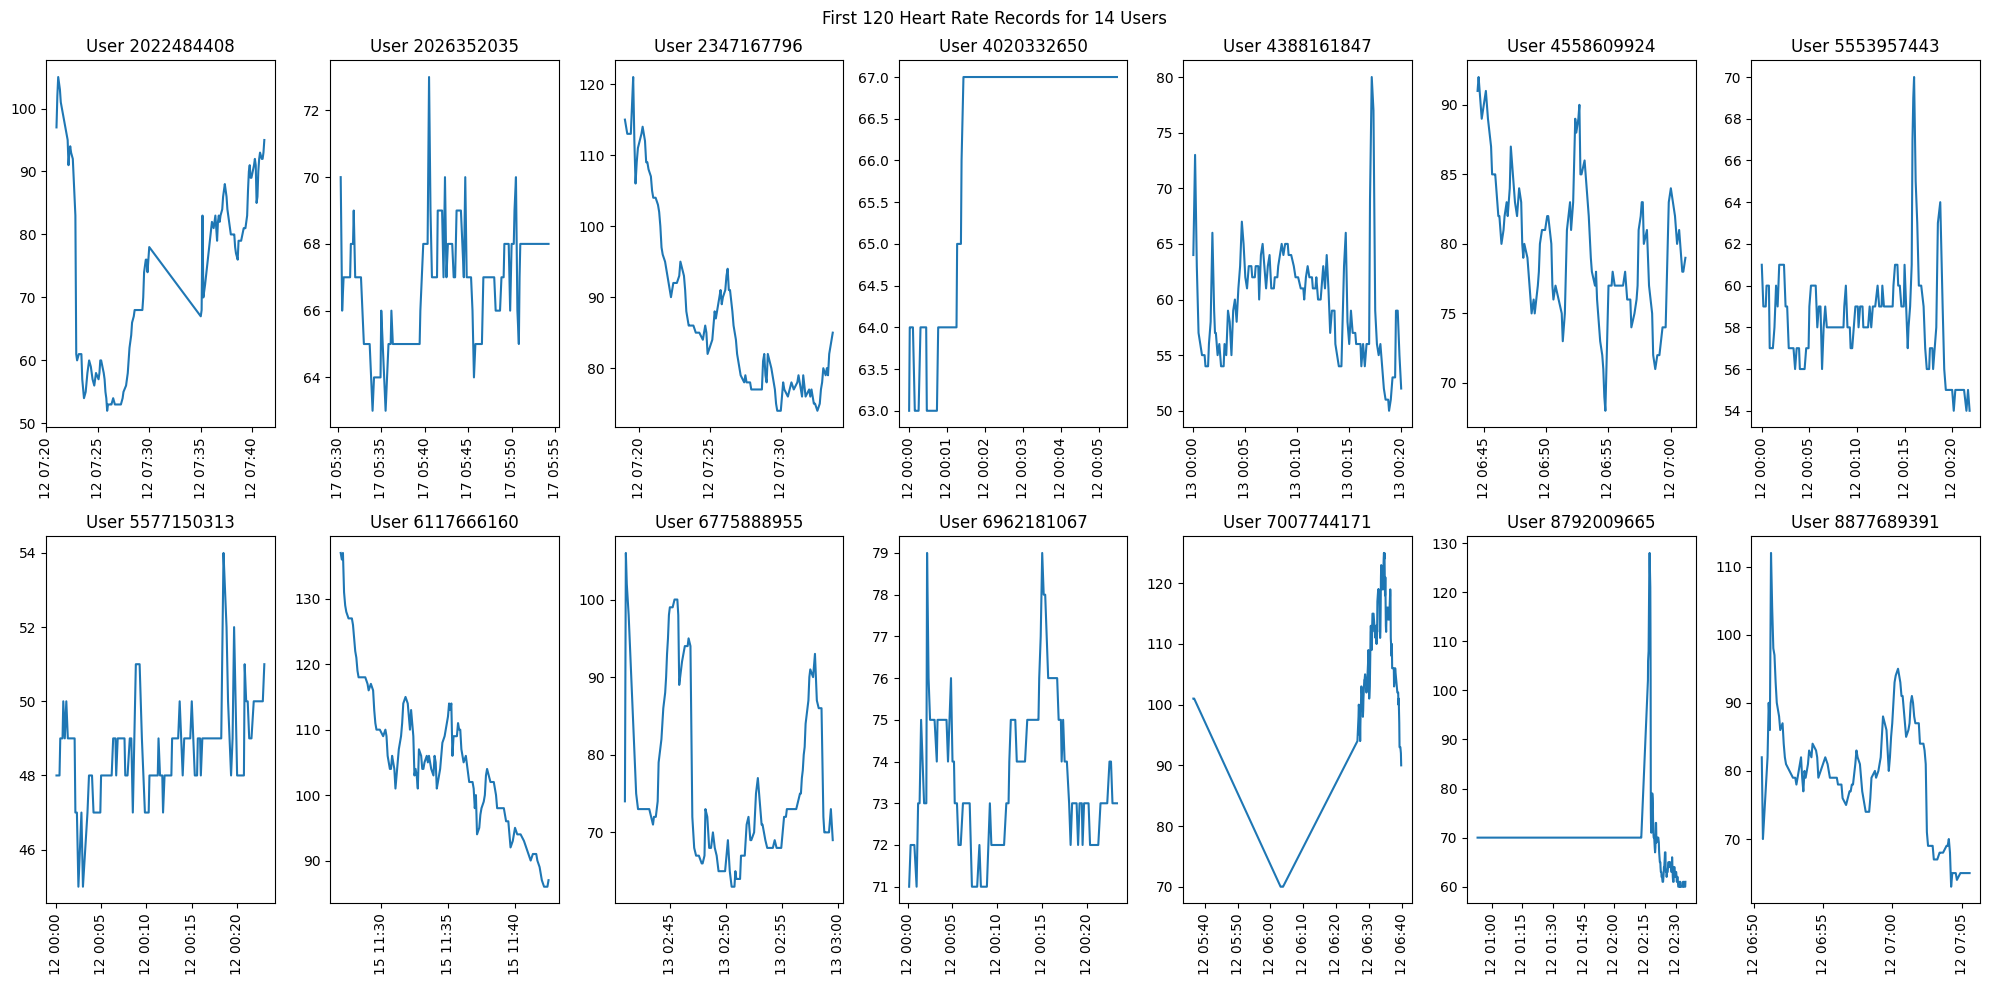

In [136]:
# create a figure with 14 subplots, arranged in 2 rows and 7 columns
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20,10))

# flatten the axes array for easy indexing
axes = axes.flatten()

# loop over the unique Id values in the data
for i, id in enumerate(heartrate_seconds_formatted['Id'].unique()):
    # select the heart rate data for this user and the first 120 records
    data = heartrate_seconds_formatted.loc[heartrate_seconds_formatted['Id'] == id][['Time', 'Value']][0:120]
    
    data.set_index('Time', inplace=True)
    
    # plot the data on the appropriate subplot
    axes[i].plot(data)
    axes[i].set_title(f"User {id}")
    
    # label time vertically
    axes[i].tick_params(axis='x', rotation=90)

# add a global title to the figure
fig.suptitle("First 120 Heart Rate Records for 14 Users")
# adjust the spacing between subplots to avoid overlapping axis labels
plt.tight_layout()
# display the plot
plt.show()


### Feature importance for predicting Calories (burned) for the daily_activity table

Even though Calories is not what we are trying to predict but the average heart rate, we do this experiment in hopes to gain insights.

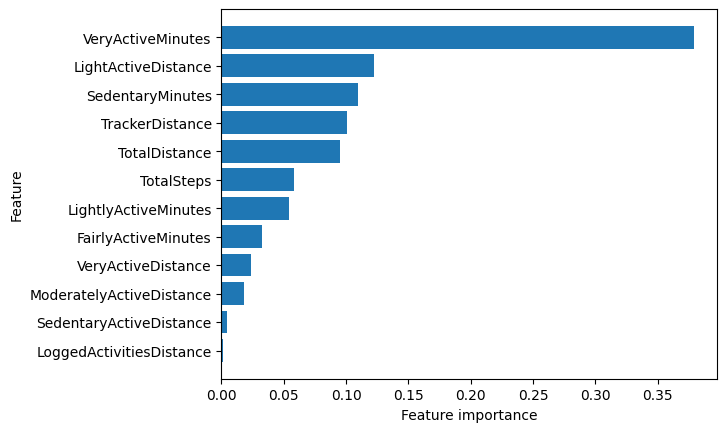

In [109]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)

X = daily_activity[['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes']]

y = daily_activity['Calories']

# Train the model on the training data
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

sorted_idx = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Select important features from the merged table (df)

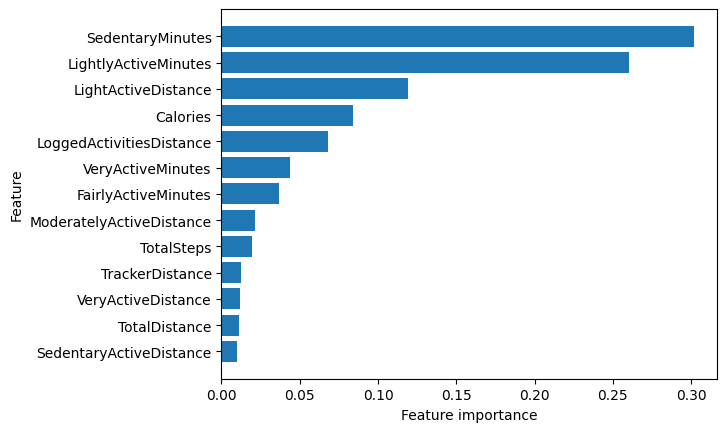

Important features: ['LoggedActivitiesDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']


In [152]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)

X = df[['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']]

y = df['Average Heart Rate']

# Train the model on the training data
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

sorted_idx = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [157]:
important_features = list(X.columns[importances > 0.03])
print(f'Important features: {important_features}')

selected_columns = important_features + ['Average Heart Rate']

Important features: ['LoggedActivitiesDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']


In [158]:
df_important = df.loc[:, selected_columns]
df_important

,LoggedActivitiesDistance,LightActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Average Heart Rate
0,0.0,4.26,42,14,227,1157,2390,76.730769
1,0.0,4.26,42,14,227,1157,2390,61.600000
2,0.0,4.26,42,14,227,1157,2390,78.000000
3,0.0,4.26,42,14,227,1157,2390,81.292683
4,0.0,4.26,42,14,227,1157,2390,88.444444
...,...,...,...,...,...,...,...,...
67513,0.0,4.25,23,1,137,770,1849,58.583333
67514,0.0,4.25,23,1,137,770,1849,60.078947
67515,0.0,4.25,23,1,137,770,1849,90.285714
67516,0.0,4.25,23,1,137,770,1849,65.282051


### Standardize the data

In [159]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_important.drop(columns=['Average Heart Rate']), df_important['Average Heart Rate'], test_size=0.2, random_state=1)

In [160]:
feature_names = df_important.drop(columns=['Average Heart Rate']).columns

In [161]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training and test data
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### Sample covariance matrix heatmap graph

<AxesSubplot: >

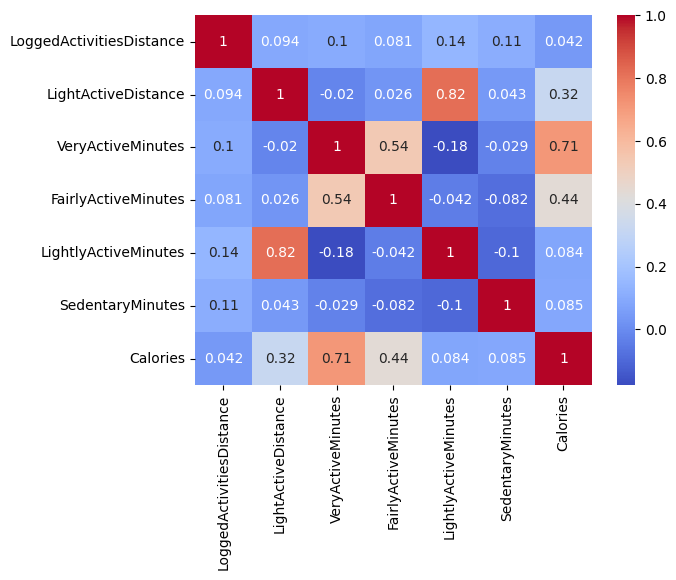

In [162]:
cov_mat = pd.DataFrame(X_train_std, columns=feature_names).cov()

# plot the heatmap
sns.heatmap(cov_mat, annot=True, cmap='coolwarm')

Main observations:
* LightActiveDistance is highly correlated with LightlyActiveMinutes, which is positively correlated with Calories.
* Calories is highly correlated with VeryActiveMinutes, which is in turn correlated with FairlyActiveMinutes.

General conclusion:
* A lot of features are correlated to each other.

# Regression Analysis